#Unzipping the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Dataset/traffic-sign-dataset_large.zip

#Importing the Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import random
from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import resnet50, InceptionV3, DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sns.set_style('whitegrid')
sns.set()
%matplotlib inline

#Loading the Labels Datasets

In [ ]:
df= pd.read_csv('/content/traffic-sign-dataset/class_labels.csv')

In [ ]:
df2= pd.read_csv('/content/traffic-sign-dataset/class_labels_ml.csv')

In [ ]:
d=df['Name'].unique()
len(d)

55

#Machine Learning Model

##Collecting Image Paths and Labels for Traffic Sign Dataset

In [ ]:
data_dir = "/content/traffic-sign-dataset/Traffic_Data/Data"

image_paths = []
labels = []

classes = os.listdir(data_dir)
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    files = os.listdir(class_dir)

    for file in files:
        image_paths.append(os.path.join(class_dir, file))
        labels.append(class_name)

##Preprocessing and Feature Extraction with HOG (Histogram of Oriented Gradients)

In [ ]:
max_feature_length = 0
features = []
for path in image_paths:
    image = imread(path, as_gray=True)
    image = rescale(image, 0.6)
    feature_vector = hog(image)
    features.append(feature_vector)
    max_feature_length = max(max_feature_length, len(feature_vector))


desired_feature_length = 4000
for i in range(len(features)):
    feature_vector = features[i]
    if len(feature_vector) > desired_feature_length:
        feature_vector = feature_vector[:desired_feature_length]
    elif len(feature_vector) < desired_feature_length:
        feature_vector = np.resize(feature_vector, desired_feature_length)
    features[i] = feature_vector

##Splitting Data into Training and Testing Sets

In [ ]:
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Random Forest Classifier Training and Evaluation

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9207920792079208


##Generating Classification Report

In [ ]:
class_names = np.unique(y)
mapped_class_names = []

for class_id in class_names:
    filtered_df = df2[df2['ClassId'] == int(class_id)]
    if not filtered_df.empty:
        class_name = filtered_df['Name'].values[0]
        mapped_class_names.append(class_name)
    else:
        mapped_class_names.append(str(class_id))

report = classification_report(y_test, y_pred, labels=class_names, target_names=mapped_class_names)
print(report)

                              precision    recall  f1-score   support

         Speed limit (5km/h)       0.93      0.76      0.83        33
        Speed limit (15km/h)       0.93      1.00      0.96        26
            Dont Go straight       0.95      1.00      0.97        18
                Dont Go Left       1.00      0.94      0.97        33
       Dont Go Left or Right       0.96      1.00      0.98        27
               Dont Go Right       1.00      1.00      1.00        22
     Dont overtake from Left       0.93      1.00      0.96        25
                    No Uturn       1.00      0.58      0.74        12
                      No Car       0.87      0.83      0.85        24
                     No horn       0.87      0.83      0.85        24
        Speed limit (40km/h)       1.00      0.72      0.84        29
        Speed limit (50km/h)       0.90      0.90      0.90        29
        Speed limit (30km/h)       1.00      1.00      1.00        27
        Go straight

##Predicting and Visualizing Traffic Sign using Random Forest Classifier and HOG Features

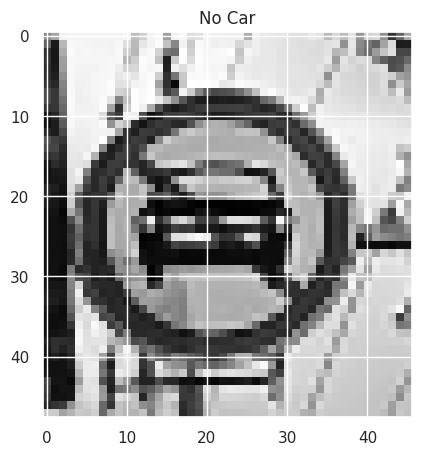

In [ ]:
image_path = '/content/traffic-sign-dataset/Traffic_Data/Test/016_0009_j.png'
image = imread(image_path, as_gray=True)
image = rescale(image, 0.6)
feature_vector = hog(image)
if len(feature_vector) > desired_feature_length:
    feature_vector = feature_vector[:desired_feature_length]
elif len(feature_vector) < desired_feature_length:
    feature_vector = np.resize(feature_vector, desired_feature_length)
reshaped_feature_vector = feature_vector.reshape(1, -1)
prediction = rf_classifier.predict(reshaped_feature_vector)[0]
class_id = int(prediction)
filtered_df = df2[df2['ClassId'] == class_id]
signature = filtered_df['Name'].values[0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, cmap='gray')
ax.set_title(signature, fontsize=12)
plt.show()

#Deep Learning Model

##Data Splitting for Training and Validation Sets

In [ ]:
def split_data(data_dir, save_dir, train_ratio,valid_ratio):
    train_dir = os.path.join(save_dir, 'train')
    valid_dir = os.path.join(save_dir, 'valid')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        train_class_dir = os.path.join(train_dir, class_name)
        valid_class_dir = os.path.join(valid_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(valid_class_dir, exist_ok=True)

        files = os.listdir(class_dir)
        random.shuffle(files)

        total_files = len(files)
        train_split = int(train_ratio * total_files)
        train_files = files[:train_split]
        valid_files = files[train_split:]

        for file in train_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(train_class_dir, file)
            shutil.copyfile(src, dst)

        for file in valid_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(valid_class_dir, file)
            shutil.copyfile(src, dst)

    print("Data split into train, valid, and test directories.")
data_dir = "/content/traffic-sign-dataset/Traffic_Data/Data"
save_dir = "/content/split_data"

train_ratio = 0.85
valid_ratio = 0.15
split_data(data_dir, save_dir, train_ratio, valid_ratio)

Data split into train, valid, and test directories.


##Image Data Augmentation and Training Set Generation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10)
training_set = train_datagen.flow_from_directory('/content/split_data/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
training_set.class_indices

Found 20123 images belonging to 58 classes.


{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '50': 46,
 '51': 47,
 '52': 48,
 '53': 49,
 '54': 50,
 '55': 51,
 '56': 52,
 '57': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57}

##Validation Set Generation

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_set = validation_datagen.flow_from_directory('/content/split_data/valid',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
validation_set.class_indices

Found 3580 images belonging to 58 classes.


{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '50': 46,
 '51': 47,
 '52': 48,
 '53': 49,
 '54': 50,
 '55': 51,
 '56': 52,
 '57': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57}

##Displaying Sample Images with Labels from the Training Set

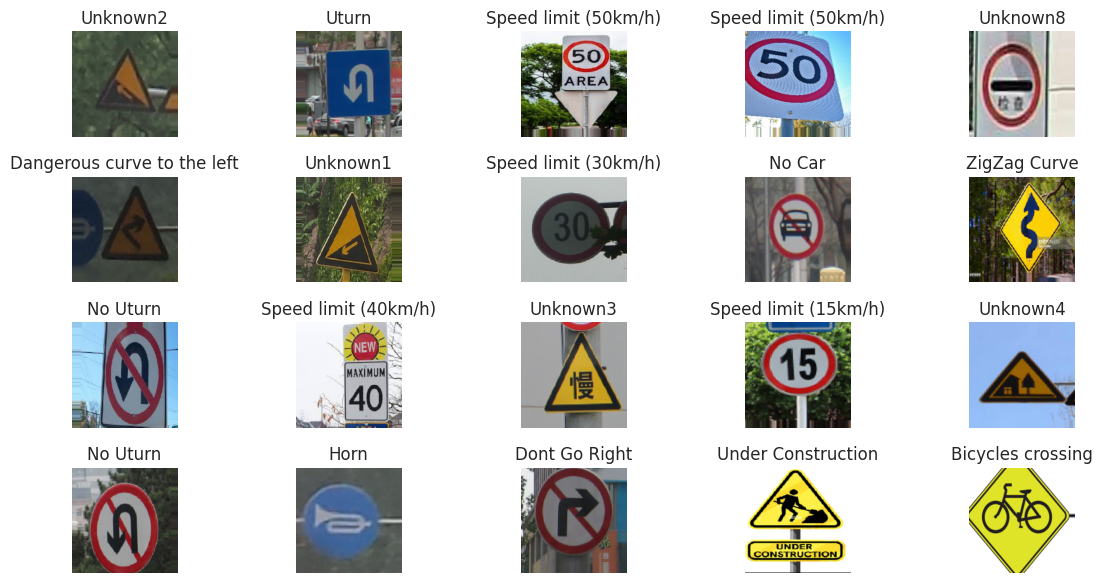

In [ ]:
t_img , label = training_set.next()

def plotImages(img_arr, labels, df):
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 6))
    count = 0
    for row in axs:
        for ax in row:
            ax.imshow(img_arr[count])
            class_id = np.argmax(labels[count])
            filtered_df = df[df['ClassId'] == class_id]
            label_name = filtered_df['Name'].values[0]
            ax.set_title(label_name)
            ax.axis('off')
            count += 1
            if count == 20:
                break
        if count == 20:
            break
    plt.tight_layout()
    plt.show()


plotImages(t_img, label,df)

##Transfer Learning with InceptionV3 for Image Classification

In [ ]:
base_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
x = base_model.output
x= Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x= Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(58, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_95[0][0]']              
 ormalization)                  )                                                           

##Model Training and Evaluation

In [ ]:
history=model.fit(training_set, validation_data=validation_set, epochs = 25)

Epoch 1/25
 12/629 [..............................] - ETA: 4:27 - loss: 3.9172 - accuracy: 0.0964

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


629/629 [==============================] - 385s 541ms/step - loss: 0.9872 - accuracy: 0.7331 - val_loss: 0.7583 - val_accuracy: 0.7796
Epoch 2/25
629/629 [==============================] - 329s 522ms/step - loss: 0.3196 - accuracy: 0.9047 - val_loss: 0.3780 - val_accuracy: 0.8818
Epoch 3/25
629/629 [==============================] - 331s 526ms/step - loss: 0.2343 - accuracy: 0.9299 - val_loss: 0.1915 - val_accuracy: 0.9369
Epoch 4/25
629/629 [==============================] - 330s 524ms/step - loss: 0.1916 - accuracy: 0.9390 - val_loss: 0.9849 - val_accuracy: 0.7852
Epoch 5/25
629/629 [==============================] - 329s 523ms/step - loss: 0.1924 - accuracy: 0.9382 - val_loss: 0.2507 - val_accuracy: 0.9399
Epoch 6/25
629/629 [==============================] - 330s 524ms/step - loss: 0.1282 - accuracy: 0.9543 - val_loss: 0.1703 - val_accuracy: 0.9475
Epoch 7/25
629/629 [==============================] - 327s 519ms/step - loss: 0.1443 - accuracy: 0.9514 - val_loss: 0.1387 - val_accura

In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/traffic_inceptionv8.h5")

##Plotting Training and Validation Accuracy/Loss

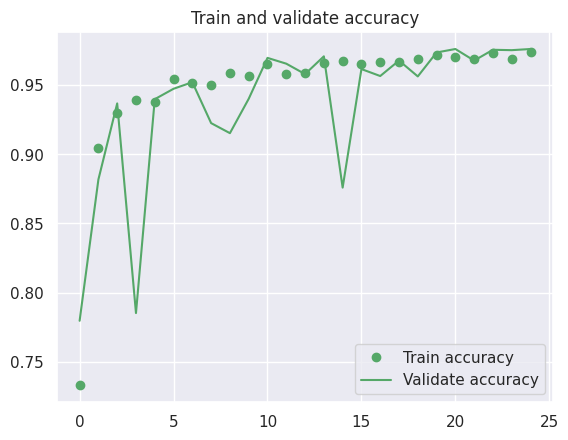

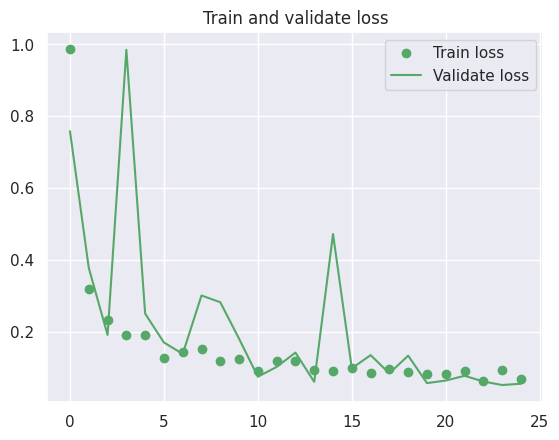

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

##Visualization of Activation Maps for a Specific Layer in an Image

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_96'
img_path = '/content/split_data/valid/10/010_0005.png'

visualize_activation_maps(model, img_path, layer_name)

Output hidden; open in https://colab.research.google.com to view.

##Evaluating Model Performance on Training and Validation Sets

In [ ]:
train = model.evaluate(training_set)
valid = model.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])

112/112 [==============================] - 13s 115ms/step - loss: 0.0556 - accuracy: 0.9763
                                        
                                        
Train Loss:  0.05435463413596153
Train Accuracy:  0.9773890376091003
                                        
                                        
Validation Loss:  0.05555419623851776
Validation Accuracy:  0.9762569665908813


##Image Prediction and Visualization

3


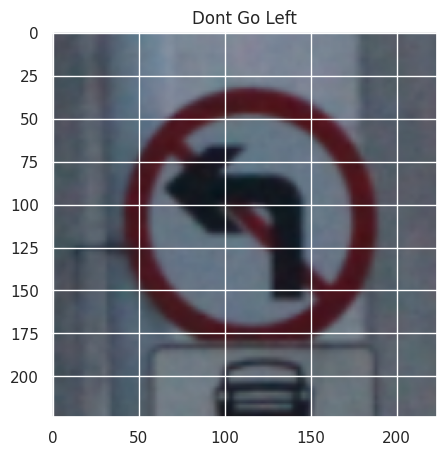

In [ ]:
img = cv2.imread('/content/split_data/valid/11/011_0005.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.resize(gray, (224, 224))
gray = gray / 255.0

pred = model.predict(np.expand_dims(gray, axis=0), verbose=False)[0].argmax()
print(pred)
classid_value = pred
filtered_df = df[df['ClassId'] == classid_value]
signature = filtered_df['Name'].values[0]

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(gray, cmap='gray')
ax.set_title(signature, fontsize=12)
plt.show()